In [1]:
import time
import numpy as np
import os
import _pickle as cPickle
import numpy as np
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import label_to_name as IMAGENET_CLASS_NAMES
import pycuda.autoinit
import pycuda.driver as drv
import numpy
from PIL import Image
import imagehash

from pycuda.compiler import SourceModule

PATH = "../data/cifar-10-batches-py/"
IMAGENET_PATH = "../data/Imagenet32_train/"

### Data Cifar-10

In [2]:
def load_batch(batchFile):
    f = open(PATH+batchFile, 'rb')
    
    dict_ = cPickle.load(f, encoding='latin1')
    images = dict_['data']
    labels = dict_['labels']
    imagearray = np.array(images)   #   (10000, 3072)
    labelarray = np.array(labels)   #   (10000,)
    
    return imagearray, labelarray

def load_classes():
    file = 'batches.meta'
    
    f = open(PATH+file, 'rb')
    dict = cPickle.load(f)
    return dict['label_names']

In [3]:
CIFAR_IMAGES, CIFAR_LABELS = load_batch("data_batch_1")
CIFAR_CLASS_NAMES = load_classes()
CIFAR_IMAGES.shape

(10000, 3072)

### LSH

In [4]:
def calculate_signature_np(image_file: np.array, hash_size: int) -> np.ndarray:
    pil_image = Image.fromarray(image_file).convert("L").resize(
                        (hash_size+1, hash_size),
                        Image.BILINEAR)
    dhash = imagehash.dhash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()
    return signature

In [5]:
from typing import List, Dict, Tuple

class LSH:
    def __init__(self, size, hash_size):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size**2 / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = dict()
        self.hash_size = hash_size

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):  # shingels
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)
    
    def compute_hash(self, images):
        idx = 0;
        for image in images:
            signature = calculate_signature_np(image.T, self.hash_size)
            self.signatures[idx] = np.packbits(signature.astype(np.uint8))
            self.fill_buckets(signature, idx)
            idx+=1
        return self.signatures

    def compute_candidate(self):
        candidate_pairs = set()
        
        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket) # Why needed ?
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.add(
                                tuple([hash_bucket[i],hash_bucket[j]])
                            )
        return candidate_pairs

    def check_candidate(self, candidate_pairs, threshold=0.9):
        
        near_duplicates = list()
        for cpa, cpb in candidate_pairs:
            hd = sum(np.bitwise_xor(
                    np.unpackbits(self.signatures[cpa]), 
                    np.unpackbits(self.signatures[cpb])
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates
            
    

### CuLSH

In [6]:
mod = SourceModule("""

#include <cmath>

__global__ void ResizeAndGray1000ImagesInterpotedHash(float* image, float* hash, const int pixels, const int new_rows, 
                                        const int new_cols, const int amountOfImages, const int hashSize)
{

    int idx           = threadIdx.x + blockIdx.x * blockDim.x;
    float* pixelsValues = new float [new_rows * new_cols];

    const float originImageSize = 32;
    float xRatio = originImageSize / new_cols;
    float yRatio = originImageSize / new_rows;

    if ( xRatio < yRatio ) xRatio = yRatio;
    
    if (idx > amountOfImages) return;

    int imageStartIdx = pixels * pixels * 3 * idx;
    
    for( int i=0; i<new_rows; i++ )
    {
        for ( int j=0; j<new_cols; j++)
        {
            float xPixel = i*yRatio;
            float yPixel = j*xRatio;

            const int x_l = floor(xPixel);  // x lower
            const int y_l = floor(yPixel);
            const int x_h = ceil(xPixel);   // x higher
            const int y_h = ceil(yPixel);

            const float x_weight = xPixel - x_l;
            const float y_weight = yPixel - y_l;

            const int pixelToTakeA = imageStartIdx + x_l * 32 + y_l;
            const int pixelToTakeB = imageStartIdx + x_h * 32 + y_l;
            const int pixelToTakeC = imageStartIdx + x_l * 32 + y_h;
            const int pixelToTakeD = imageStartIdx + x_h * 32 + y_h;
            
            const float a = 0.2989 * image[pixelToTakeA] + 0.5870 * image[1024+pixelToTakeA] + 0.1140 * image[2048+pixelToTakeA];
            const float b = 0.2989 * image[pixelToTakeB] + 0.5870 * image[1024+pixelToTakeB] + 0.1140 * image[2048+pixelToTakeB];
            const float c = 0.2989 * image[pixelToTakeC] + 0.5870 * image[1024+pixelToTakeC] + 0.1140 * image[2048+pixelToTakeC];
            const float d = 0.2989 * image[pixelToTakeD] + 0.5870 * image[1024+pixelToTakeD] + 0.1140 * image[2048+pixelToTakeD];

            const float pixel = a * (1 - x_weight) * (1 - y_weight) 
              + b * x_weight * (1 - y_weight) +
              c * y_weight * (1 - x_weight) +
              d * x_weight * y_weight;
              
            pixelsValues[i * new_rows + j ] = pixel;
        }
    }

    for( int i=0; i<new_rows; i++ )
    {
        for ( int j=1; j<new_cols; j++)
        {
            pixelsValues[i*new_rows+j-1] < pixelsValues[i*new_rows+j] ? 
                hash[hashSize*idx+i*new_rows+j-1] = 1 : hash[hashSize*idx+i*new_rows+j-1] = 0;
        }
    }

    delete pixelsValues;

    __syncthreads();
}

""")

ResizeAndGray1000ImagesInterpotedHash = mod.get_function("ResizeAndGray1000ImagesInterpotedHash")

In [7]:
mod = SourceModule("""

__global__ void ComparePairs(float* pairs, float* signatures, float* res, float threshold, float hash_size, int pairsElements)
{
    unsigned int x = blockIdx.x * blockDim.x + threadIdx.x;

    if(x > pairsElements) return;

    const int bitsNumbers = hash_size * hash_size / 8;
    const int imageIdx1 = pairs[x*2];
    const int imageIdx2 = pairs[x*2+1];
    unsigned int hammingDistance = 0;
    
    for(int i=0; i<bitsNumbers; i++)
    {
        unsigned int common = (unsigned int)signatures[imageIdx1*bitsNumbers+i] ^ (unsigned int)signatures[imageIdx2*bitsNumbers+i];

         while ( common>0 )
         {
            unsigned int val = common&1;
            common>>=1;
            hammingDistance += val;
        }
    }

    float similarity = (hash_size * hash_size - hammingDistance) / ( hash_size * hash_size );

    if ( similarity >= threshold )
    {
        res[x] = similarity;
    }
}

""")

ComparePairs = mod.get_function("ComparePairs")

In [8]:
from typing import List, Dict, Tuple

class cuLSH:
    def __init__(self, size, hash_size, images):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size**2 / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = numpy.zeros([len(images), hash_size // 8 * hash_size]).astype(numpy.float32)
        self.hash_size = hash_size
        self.images = images;

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)

    def compute_hash(self):
        idx = 0
        for i in range(0, 10):
            signature_1000 = numpy.zeros([1000 * self.hash_size**2 ]).astype(numpy.float32)
            INPUT_IMAGES = self.images[1000*i:1000*i+1000].astype(numpy.float32).reshape(1000 * 1024 * 3)
            ResizeAndGray1000ImagesInterpotedHash(drv.In(INPUT_IMAGES), drv.Out(signature_1000), np.int32(32), 
                        np.int32(self.hash_size), np.int32(self.hash_size+1), np.int32(1000), np.int32(self.hash_size**2),
                        block=(1000,1,1))

            for j in range(0, 1000):
                one_signature = signature_1000[self.hash_size**2 * j: self.hash_size**2 * j+ self.hash_size**2]
                self.signatures[idx] = np.packbits(one_signature.astype(np.int8)).astype(np.float32)
                self.fill_buckets(one_signature, idx)
                idx += 1
    
    def compute_candidate(self):
        candidate_pairs = []

        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket)
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.append(hash_bucket[i])
                            candidate_pairs.append(hash_bucket[j])
        return candidate_pairs

    def check_candidate(self, candidate_pairs, threshold=0.9):
        pairsNumpy = numpy.asarray(candidate_pairs, dtype=np.float32)
        signaturesReshaped = self.signatures.reshape(-1)

        near_duplicates = list()
        
        for i in range(0, pairsNumpy.shape[0], 1000000):
            resSimilarity = numpy.zeros([500000]).astype(numpy.float32)
            ComparePairs(drv.In(pairsNumpy), drv.In(signaturesReshaped), drv.Out(resSimilarity), 
                         np.float32(threshold), np.float32(self.hash_size), np.int32(pairsNumpy.shape[0]//2),
                         block=(1000,1,1), grid=(500,1,1))

            for j in range (0, 1000000, 2):
                if i+j >= pairsNumpy.shape[0]:
                    break;
                if resSimilarity[j//2] > 0:
                    near_duplicates.append( ( int(pairsNumpy[i+j]), int(pairsNumpy[i + j + 1]), resSimilarity[j//2] ) )

        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates

### Tests

In [9]:
arr1 = []
pairsTotal = []
pairs = []

lsh = LSH(8, 8)
lsh.compute_hash(CIFAR_IMAGES)

for i in range(1):
    start = time.time()
    pairs = lsh.compute_candidate()

    end = time.time()
    arr1.append( end - start )
    pairsTotal.append(len(pairs))
    print( "time: ", end - start )

print(sum(arr1) / len(arr1))
print(pairsTotal)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7bb044cf48e0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



In [10]:
arr2 = []
pairsTotal2 = []
pairs2 = []
duplicates = []

cuLsh = cuLSH(8, 8, CIFAR_IMAGES)
cuLsh.compute_hash()
pairs2 = cuLsh.compute_candidate()
for i in range(1):
    start = time.time()
    duplicates = cuLsh.check_candidate(pairs2)
    end = time.time()
    arr2.append( end - start )
    pairsTotal2.append(len(pairs2))
    print( "time: ", end - start )

print(sum(arr2) / len(arr2))
print(pairsTotal2)
print(duplicates)
print(len(duplicates))

time:  3.534742832183838
3.534742832183838
[3883906]
[(8975, 9432, 0.984375), (3977, 5711, 0.984375), (824, 8157, 0.984375), (812, 7224, 0.984375), (4875, 9275, 0.96875), (1981, 4527, 0.96875), (7566, 7584, 0.96875), (661, 2210, 0.953125), (5301, 8775, 0.953125), (4284, 7838, 0.953125), (3785, 6974, 0.953125), (3789, 4651, 0.9375), (3789, 4651, 0.9375), (7314, 8960, 0.9375), (28, 2205, 0.9375), (2013, 9069, 0.9375), (7250, 8638, 0.9375), (57, 5894, 0.9375), (6295, 7038, 0.9375), (2137, 9702, 0.921875), (2474, 8049, 0.921875), (994, 1743, 0.921875), (3439, 5763, 0.921875), (3789, 5839, 0.90625), (100, 9206, 0.90625), (8443, 9206, 0.90625), (3789, 5839, 0.90625), (100, 9206, 0.90625), (6632, 8443, 0.90625), (8443, 9206, 0.90625), (7571, 9314, 0.90625), (2457, 9122, 0.90625), (6891, 9292, 0.90625), (28, 6756, 0.90625), (5955, 9192, 0.90625), (508, 6001, 0.90625), (6001, 8212, 0.90625), (2337, 6315, 0.90625), (2649, 5620, 0.90625), (2049, 6002, 0.90625), (7444, 8068, 0.90625), (9358, 9838,

In [15]:
withoutLastElements = 0#577600
sumTrueDuplicates = 0
for i in range( len(duplicates) - withoutLastElements ):
    if CIFAR_LABELS[duplicates[i][0]] == CIFAR_LABELS[duplicates[i][1]]:
        sumTrueDuplicates += 1
        

print("True duplicates: ", sumTrueDuplicates)
print("All duplicates: ", len(duplicates) - withoutLastElements )
acc = sumTrueDuplicates / ( len(duplicates) - withoutLastElements )
print(acc)

True duplicates:  12
All duplicates:  51
0.23529411764705882


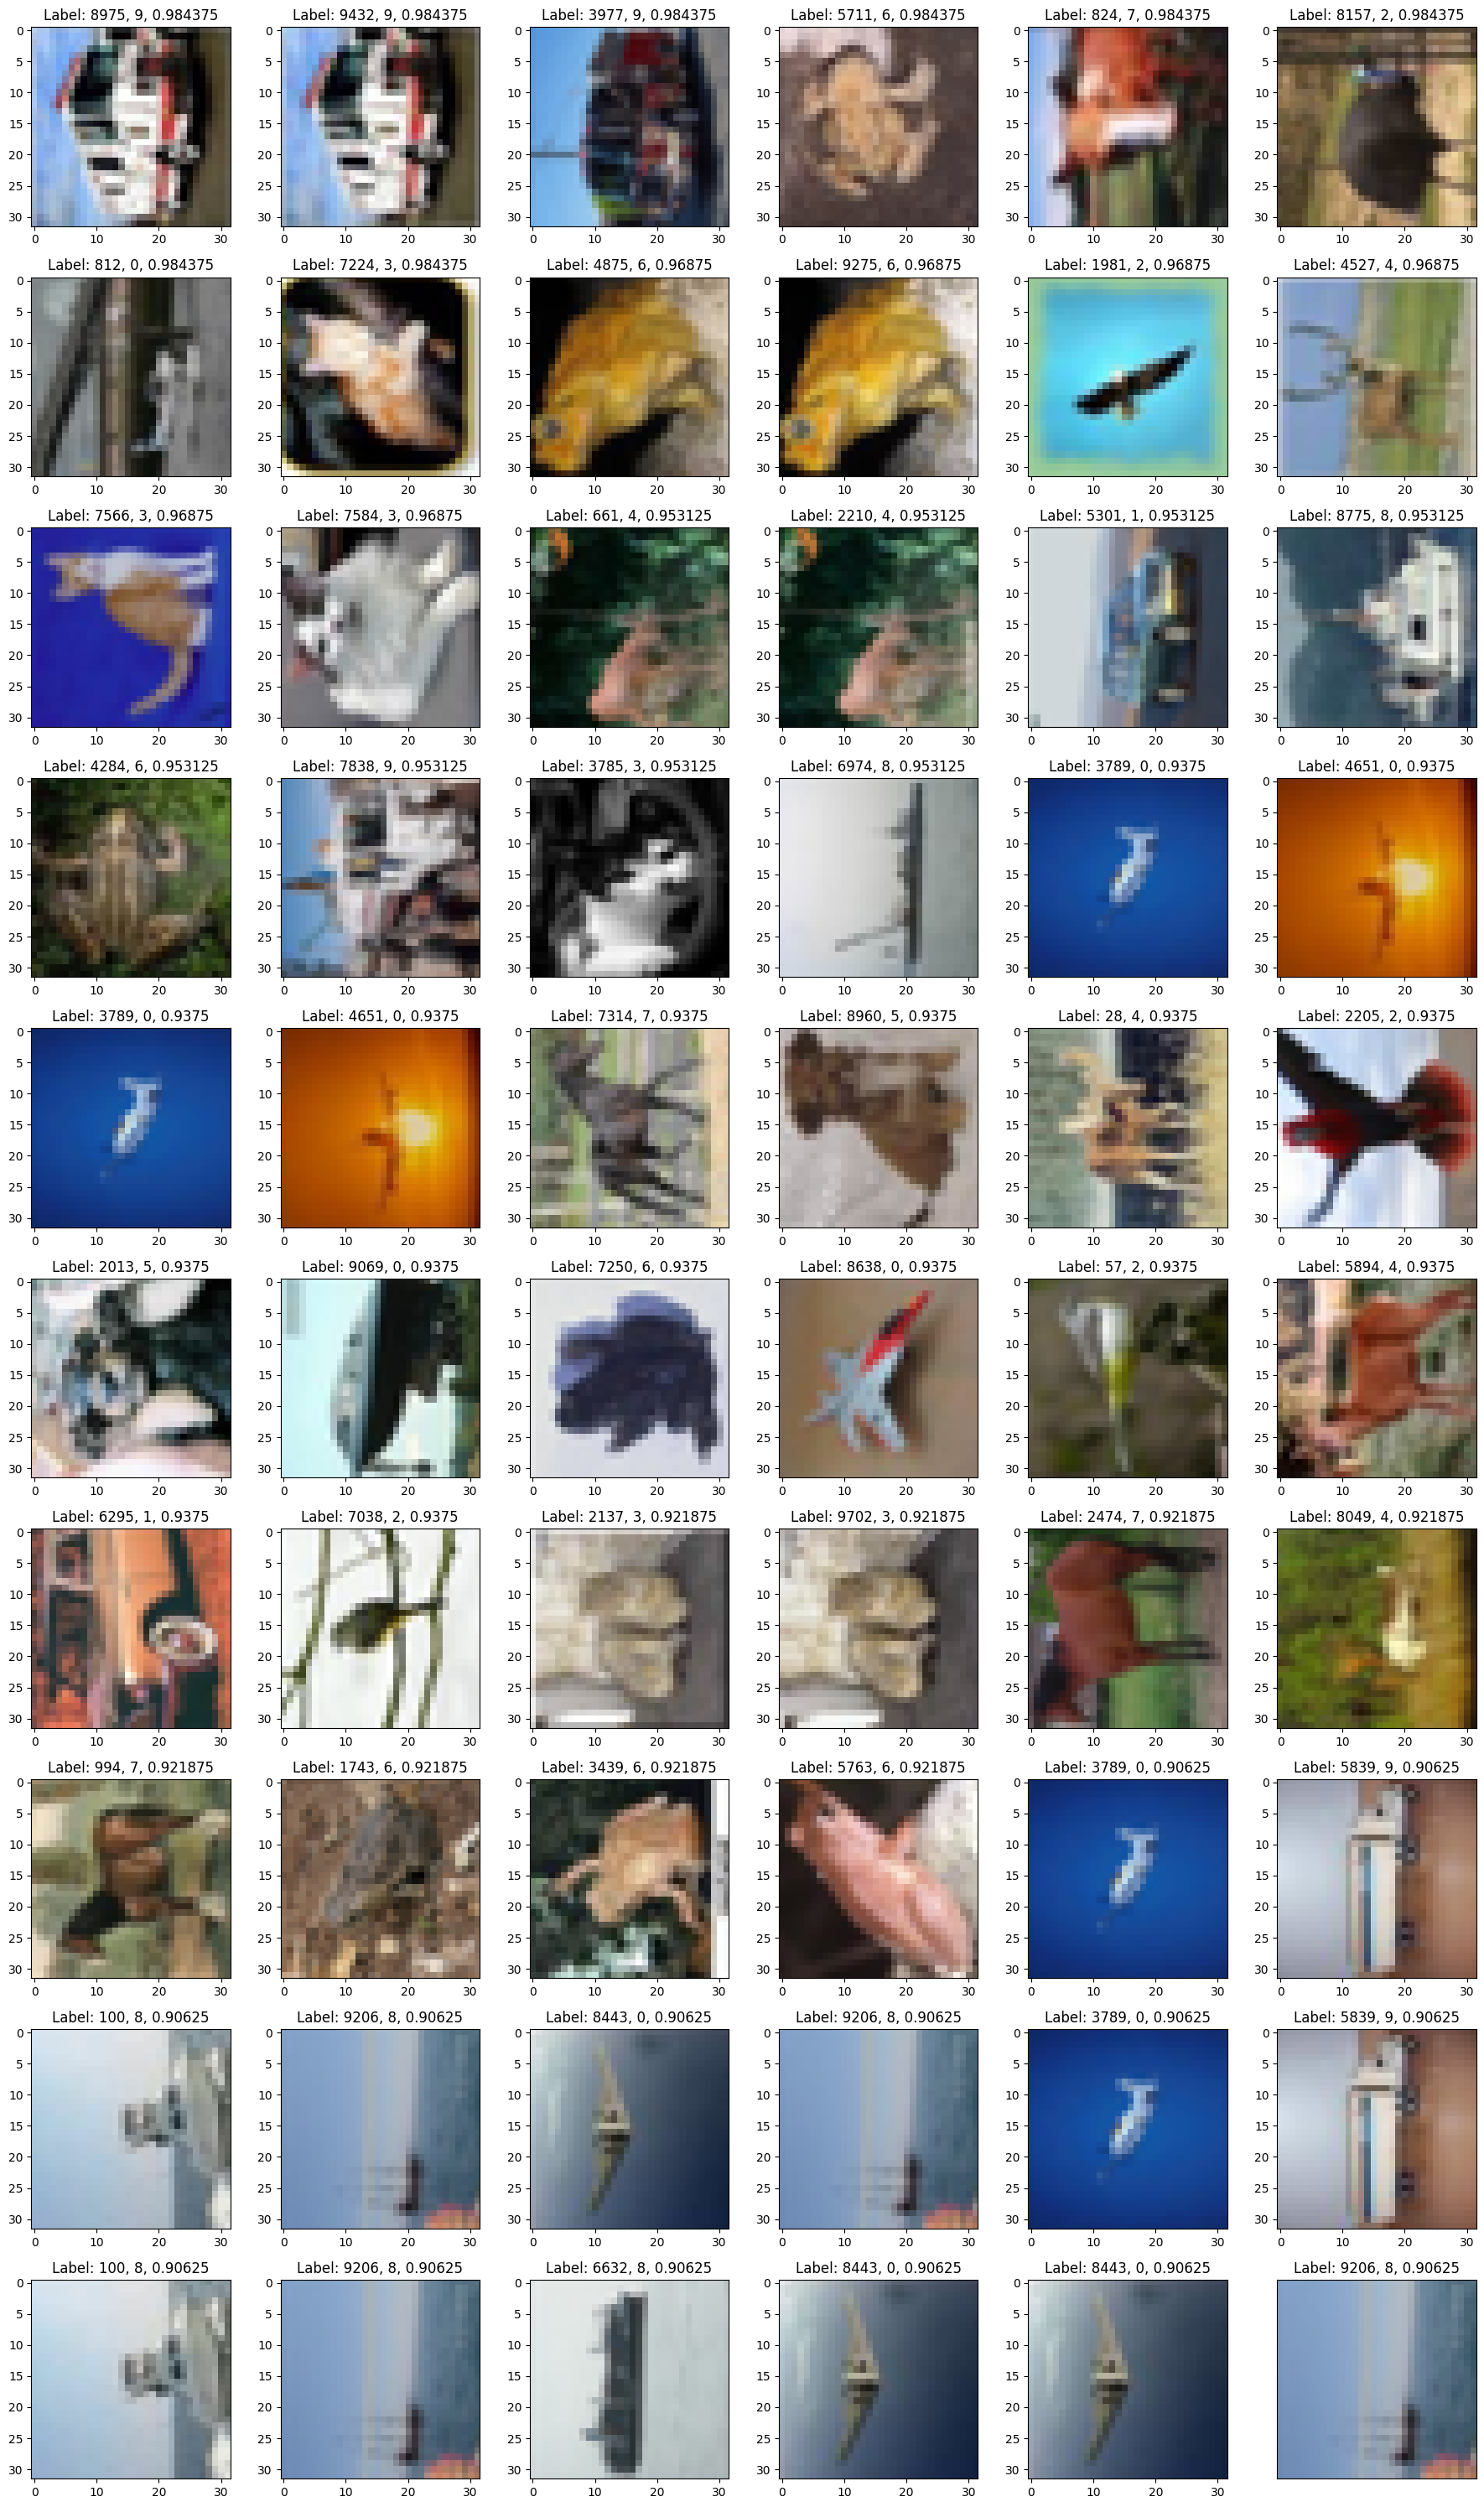

In [11]:
from matplotlib import pyplot as plt

num_row = 10
num_col = 6

idx_start = 0;

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col, 2):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(CIFAR_IMAGES[duplicates[i//2 + idx_start][0]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {duplicates[i//2 + idx_start][0]}, {CIFAR_LABELS[duplicates[i//2 + idx_start][0]]}, {duplicates[i//2 + idx_start][2]}""")

    ax = axes[(i+1)//num_col, (i+1)%num_col]
    ax.imshow(CIFAR_IMAGES[duplicates[i//2 + idx_start][1]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {duplicates[i//2 + idx_start][1]}, {CIFAR_LABELS[duplicates[i//2 + idx_start][1]]}, {duplicates[i//2 + idx_start][2]}""")

plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()

### Total Full check

In [25]:
cuLshTotal = cuLSH(8, 8, CIFAR_IMAGES)
cuLshTotal.compute_hash()
pairs2 = cuLshTotal.compute_candidate()
duplicates = cuLshTotal.check_candidate(pairs2)

In [28]:
duplicates

3883906